# 10 Monkey Species Image Dataset Analysis

Module: CS985 Machine Learning For Data Analytics

Student: Rokas Labeikis

Student ID: 201349799

## Objective and problem

The core problem of the assignment is to classify any image (with monkeys in it) from a list into 1 of 10 classes.

The objective is to create an sufficient classifier which performs well. However, more importantly for the author is to learn and explore machine learning framework Tensorflow. Due to the later reason, more than 1 approach of image classification will be researched and the performance of the models will not be considered a priority.

Explored techniques include:
- Linear image classification;
- Transfer learning;
- Convolutional Neural Networks.

## Development environment

In [6]:
# Importing neccesary modules
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import os
import cv2
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import platform
from __future__ import division
warnings.resetwarnings()

# Versions used
print('TensorFlow version: ', tf.__version__)
print('Python version: ', platform.python_version())

('TensorFlow version: ', '1.7.0')
('Python version: ', '2.7.13')


## Introduction to the dataset

Chosen dataset was taken from www.kaggle.com and it is called "10 Monkey Species". The original dataset consists of 2 directories ("training" and "validation") and a text file containing all the labels and titles. Each directory  contains 10 subdirectories, labeled from "n0" to "n9". Finally, each subdirectory contains a series of images (images are 400x300 px or larger and JPEG format) of a certain class.

Below the contents of the "monkey_labels.txt" file are presented. The table encompasses the overall structure of the dataset.

In [7]:
info = pd.read_csv("input/monkey_labels.txt", names=['Label','Latin Name', 'Common Name','Train Images', 'Validation Images'], skiprows=1)
info

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


## Obtaining and preparing the dataset

In [8]:
# Defining input directory paths
train_dir = 'input/training'
test_dir = 'input/validation'

Below "read_data" function is defined. This function takes an directory as an input and produces a data frame after its done. The produced data frame consist of numerical image representation, its label, path to the real image, integer encoded label and one hot encoded label. 

In [10]:
def read_data(filename):
    images = []
    labels = []
    paths = []
    i = 0
    for dir_path in glob.glob(filename + "/*"):
        label = dir_path.split("/")[-1]
        for image_path in glob.glob(os.path.join(dir_path, "*.jpg")):
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            # Adjust stored image size if necessary
            image = cv2.resize(image, (1, 1))
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            
            labels.append(label)
            images.append(image)
            paths.append(image_path)
            
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(labels)
    # one hot binary encode 
    onehot_encoder = OneHotEncoder(sparse=False)
    i_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(i_encoded)
    
    d = {'images':images,'labels':labels, 'path': paths, 'int':integer_encoded, 'hot': onehot_encoded.tolist()}

    df = pd.DataFrame(d)
    return df

train = read_data(train_dir)
test = read_data(test_dir)
# Write data to csv files for future use 
train.to_csv('./input/train.csv', index=False) 
test.to_csv('./input/test.csv',  index=False)

In [13]:
train.head() #generated dataframe for training

,hot,images,int,labels,path
0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[215, 209, 194]]]",3,n3,input/training/n3/n3049.jpg
1,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[90, 73, 65]]]",3,n3,input/training/n3/n3133.jpg
2,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[170, 167, 157]]]",3,n3,input/training/n3/n3170.jpg
3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[142, 132, 133]]]",3,n3,input/training/n3/n3064.jpg
4,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[228, 235, 245]]]",3,n3,input/training/n3/n3135.jpg


Some checks to make sure everything went smoothly with the input reading.

In [11]:
train.isnull().sum() # checking for missing values in the dataframe

hot       0
images    0
int       0
labels    0
path      0
dtype: int64

In [12]:
test.isnull().sum()

hot       0
images    0
int       0
labels    0
path      0
dtype: int64

In [14]:
print(train.columns)

Index([u'hot', u'images', u'int', u'labels', u'path'], dtype='object')


## Exploring the dataset

There are 1096 images dedicated for model training and 272 for testing. In total there are 1368 number of images.

In [44]:
print(train.shape)
print(test.shape)
print("Total entries: ", len(train)+len(test))

(1096, 5)
(272, 5)
('Total entries: ', 1368)


9 images along with their labels are printed below. This is done in order to see the type of images we are dealing with and if the labels are matching correctly.

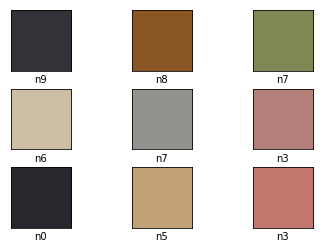

In [42]:
def plot_images(images, labels):
    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images.iloc[i])  

        ax.set_xlabel(labels.iloc[i])
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()
    


# Get 10 random images from the test-set.
sample = test.sample(n=9)

# Plot the images and labels using our helper-function above.
plot_images(sample["images"], sample["labels"])


## Creating a model

### Transfer learning

In [33]:
def load_labels(label_file):
    label = []
    proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
    for l in proto_as_ascii_lines:
        label.append(l.rstrip())
    return label

def read_tensor_from_image_file(file_name,
                                input_height=299,
                                input_width=299,
                                input_mean=0,
                                input_std=255):
    input_name = "file_reader"
    output_name = "normalized"
    file_reader = tf.read_file(file_name, input_name)
   
    image_reader = tf.image.decode_jpeg(file_reader, channels=3, name="jpeg_reader")
    
    float_caster = tf.cast(image_reader, tf.float32)
    dims_expander = tf.expand_dims(float_caster, 0)
    resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
    normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
    sess = tf.Session()
    result = sess.run(normalized)
    
    return result

model_file = 'retrained_model/output_graph.pb'
label_file = 'retrained_model/output_labels.txt'
input_layer = 'Placeholder'
output_layer = 'final_result'

#load graph
graph = tf.Graph()
graph_def = tf.GraphDef()
with open(model_file, "rb") as f:
    graph_def.ParseFromString(f.read())
with graph.as_default():
    tf.import_graph_def(graph_def)

input_name = "import/" + input_layer
output_name = "import/" + output_layer
input_operation = graph.get_operation_by_name(input_name)
output_operation = graph.get_operation_by_name(output_name)

labels = load_labels(label_file)

#shuffle test dataframe
test_Tlearning = test.sample(frac=1)
correct = 0    
for index, row in test_Tlearning.iterrows():
    t = read_tensor_from_image_file(row["path"])

    with tf.Session(graph=graph) as sess:
        results = sess.run(output_operation.outputs[0], {
            input_operation.outputs[0]: t
        })
    results = np.squeeze(results)
    
    top_k = results.argsort()[-1:][::-1]
    for i in top_k:
        if (labels[i] == row["labels"]):
            print(labels[i], results[i], "Correct!")
            correct = correct + 1
        else:
            print(labels[i], results[i], "False! -Correct was: ", row["labels"], "Path:", row["path"])
            

acc = correct / len(test_paths)
print("Accuracy: ", acc)


('n1', 0.99499714, 'Correct!')
('n7', 0.9958555, 'Correct!')
('n6', 0.9874325, 'Correct!')
('n3', 0.978956, 'Correct!')
('n5', 0.99827945, 'Correct!')
('n6', 0.96657157, 'Correct!')
('n7', 0.9926466, 'Correct!')
('n5', 0.9963971, 'Correct!')
('n2', 0.9078938, 'Correct!')
('n1', 0.99499714, 'Correct!')
('n0', 0.99846387, 'Correct!')
('n1', 0.92250466, 'Correct!')
('n8', 0.99902844, 'Correct!')
('n4', 0.95408446, 'Correct!')
('n7', 0.983564, 'Correct!')
('n0', 0.99984777, 'Correct!')
('n2', 0.99017286, 'Correct!')
('n5', 0.9656844, 'Correct!')
('n9', 0.9427001, 'Correct!')
('n3', 0.91738963, 'Correct!')
('n6', 0.9933854, 'Correct!')
('n8', 0.9983078, 'Correct!')
('n3', 0.9998202, 'Correct!')
('n9', 0.9985574, 'Correct!')
('n1', 0.99181753, 'Correct!')
('n1', 0.9928041, 'Correct!')
('n9', 0.9948605, 'Correct!')
('n0', 0.9980363, 'Correct!')
('n6', 0.9931766, 'Correct!')
('n8', 0.95426494, 'Correct!')
('n5', 0.98561585, 'Correct!')
('n8', 0.99942183, 'Correct!')
('n9', 0.9328075, 'Correct!

('n5', 0.9853543, 'Correct!')
('n2', 0.9703625, 'Correct!')
('Accuracy: ', 1)


## Linear model

In [9]:
def generate_labelled_input_fn(df, batch_size):
    def input_fn():
        image_list, label_list = df["path"].tolist(), df["int"].tolist()

        def read_images_from_disk(input_queue):
            label = input_queue[1]
            file_contents = tf.read_file(input_queue[0])
            example = tf.image.decode_jpeg(file_contents, channels=3)
            example=tf.image.resize_images(example, [150, 150])
            example=tf.reshape(example, [150, 150, 3]) 
            return example, label

        images = tf.convert_to_tensor(image_list, dtype=tf.string)
        labels = tf.convert_to_tensor(label_list, dtype=tf.int32)

        # Makes an input queue
        input_queue = tf.train.slice_input_producer([images, labels], shuffle=True)

        image, label = read_images_from_disk(input_queue)
        image_batch, label_batch = tf.train.batch([image, label], batch_size=batch_size)
        return {'images':  image_batch}, label_batch
    return input_fn

In [10]:
feature_columns = [tf.feature_column.numeric_column('images', shape=[150,150,3])]

classifier = tf.estimator.LinearClassifier(
    feature_columns=feature_columns,
    n_classes=10,
    model_dir='./linear_model'
)

BATCH_SIZE = 40
TRAIN_STEPS = 100

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efc6c4a5d50>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': './linear_model', '_save_summary_steps': 100}


In [11]:
classifier.train(
    input_fn=generate_labelled_input_fn(train, BATCH_SIZE),
    steps=TRAIN_STEPS
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./linear_model/model.ckpt.
INFO:tensorflow:loss = 92.10341, step = 1
INFO:tensorflow:Saving checkpoints for 100 into ./linear_model/model.ckpt.
INFO:tensorflow:Loss for final step: 3939168.5.


In [12]:
classifier.evaluate(
    input_fn=generate_labelled_input_fn(test, BATCH_SIZE),
    steps=100
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-11-21:52:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./linear_model/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Evaluation [50/100]
INFO:tensorflow:Evaluation [60/100]
INFO:tensorflow:Evaluation [70/100]
INFO:tensorflow:Evaluation [80/100]
INFO:tensorflow:Evaluation [90/100]
INFO:tensorflow:Evaluation [100/100]
INFO:tensorflow:Finished evaluation at 2018-04-11-21:53:49
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.33825, average_loss = 90258.18, global_step = 100, loss = 3610327.0


{'accuracy': 0.33825,
 'average_loss': 90258.18,
 'global_step': 100,
 'loss': 3610327.0}

### Convolutional Neural Networks

## Validation

### Confusion matrix

## Evaluation

## Conclusion 